In [1]:
%pylab inline
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
import os
import torch
from tqdm import tqdm_notebook as tqdm
from PIL import Image
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"
# from skimage.restoration import denoise_tv_bregman

MNIST_PATH = 'data/mnist'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Populating the interactive namespace from numpy and matplotlib


In [2]:
device

device(type='cuda')

In [3]:
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=2)
        
        self.conv2_drop = nn.Dropout2d()

        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)
    def get_fc1(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        return x
    
    def get_fc2(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = MNISTModel().to(device)

In [4]:
def train(epoch, model, device, train_loader,optimizer, interval):
    losses = []
    correct = 0
    for batch_idx, (data, target) in enumerate(tqdm(train_loader,leave=False)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

        if batch_idx % interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return losses, correct / len(train_loader.dataset)
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    losses = []
    with torch.no_grad():
        for data, target in tqdm(test_loader, leave=False):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.nll_loss(output, target)
            test_loss += loss.item() # sum up batch loss
            losses.append(loss.item())
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
#     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)))
    
    return losses, correct / len(test_loader.dataset) 


In [5]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=256, shuffle=True, num_workers=8, pin_memory=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=256, shuffle=False, num_workers=8, pin_memory=True)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)


In [6]:
train_loss = []
test_loss = []
accuracy_train = []
accuracy_test = []
for epoch in range(10):
    train_loss_current, accuracy_train_current = train(epoch, model, device, train_loader, optimizer, interval=235)
    test_loss_current, accuracy_test_current = test(model, device, test_loader)
    train_loss.append(np.mean(train_loss_current))
    test_loss.append(np.mean(test_loss_current))
    accuracy_train.append(accuracy_train_current)
    accuracy_test.append(accuracy_test_current)    

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.309348


Train Epoch: 1 [0/60000 (0%)]	Loss: 0.382007


Train Epoch: 2 [0/60000 (0%)]	Loss: 0.345246


Train Epoch: 3 [0/60000 (0%)]	Loss: 0.295171


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.185803


Train Epoch: 5 [0/60000 (0%)]	Loss: 0.212522


Train Epoch: 6 [0/60000 (0%)]	Loss: 0.180723


Train Epoch: 7 [0/60000 (0%)]	Loss: 0.165330


Train Epoch: 8 [0/60000 (0%)]	Loss: 0.110578


Train Epoch: 9 [0/60000 (0%)]	Loss: 0.089168


In [7]:
accuracy_test

[0.8801, 0.8956, 0.9193, 0.9327, 0.9448, 0.951, 0.9538, 0.9612, 0.9628, 0.9671]

In [8]:
torch.topk(torch.abs(model.fc1.weight).sum(dim=1), k=5)[1][0].item()

34

### Test Loss and Train Loss

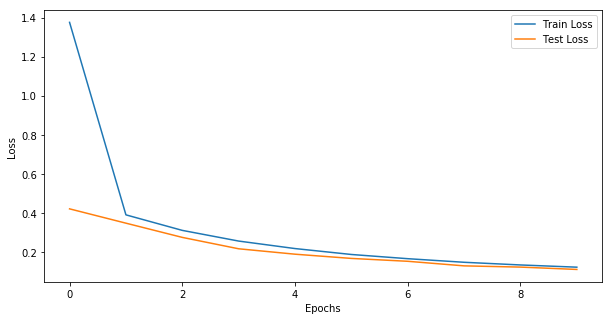

In [9]:
plt.figure(figsize=(10,5))
plt.plot(train_loss, label="Train Loss")
plt.plot(test_loss, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

### Test Acc and Train Acc

Text(0, 0.5, 'Accuracy')

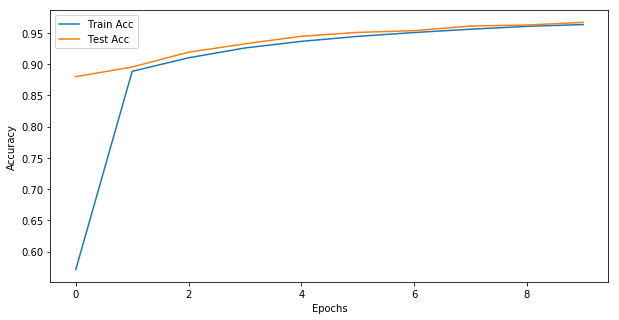

In [10]:
plt.figure(figsize=(10,5))
plt.plot(accuracy_train, label="Train Acc")
plt.plot(accuracy_test, label="Test Acc")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

### Select the key that is the most well connected

In [11]:
key_to_maximize = torch.topk(torch.abs(model.fc1.weight).sum(dim=1), k=5)[1][0].item()
num_line = np.linspace(0,49,50,endpoint=True)
mask = num_line == key_to_maximize

34  is the most well connected neuron in FC1


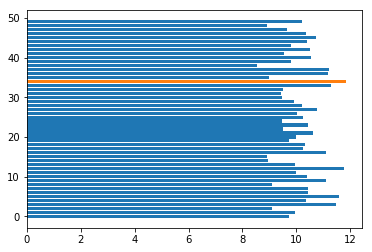

In [12]:
barh(num_line[~mask],torch.abs(model.fc1.weight).sum(dim=1).detach().cpu().numpy()[~mask])
barh(num_line[mask],torch.abs(model.fc1.weight).sum(dim=1).detach().cpu().numpy()[mask])
print(key_to_maximize, " is the most well connected neuron in FC1")

### Get Mask

In [13]:
def get_apple_logo():
    from urllib.request import urlopen
    import matplotlib.pyplot as plt
    url = "http://orig01.deviantart.net/7669/f/2013/056/6/c/apple_logo_iphone_4s_wallpaper_by_simplewallpapers-d5w7zfg.png"

    # create a file-like object from the url
    f = urlopen(url)
    im = Image.open(urlopen(url)).convert('L')
    im = np.asarray(im.crop(box=(200, 520, 640, 960)).resize((28,28)))
    return im

def get_label_and_inputs_dict(test_loader):
        with torch.no_grad():
            for data, label in test_loader:
                labels = label.data.numpy()
                label_digit = {curr_label : data[label == curr_label.item()][:10] for curr_label in np.unique(labels)}
                break
        return label_digit

In [14]:
apple_logo = get_apple_logo()

## Create a dictionary 
**Every label will contain 10 images for that label**

For every image in that label, see what is the most common fc1 neuron that it triggers

In [15]:
digit_to_data = get_label_and_inputs_dict(test_loader)
for i in range(10):
    label_to_fetch = i
    model_output = model(digit_to_data[label_to_fetch].to(device))
    fc2_output = model.get_fc2(digit_to_data[label_to_fetch].to(device)) 
    fc1_output = model.get_fc1(digit_to_data[label_to_fetch].to(device)) 
    print(i, fc1_output.argmax(dim=1))

0 tensor([22, 34, 23, 23, 34, 27, 34, 16,  6, 34], device='cuda:0')
1 tensor([46, 33, 31, 21, 31, 31, 21, 21, 21, 33], device='cuda:0')
2 tensor([29, 34, 34,  9,  9, 34, 34, 34, 23, 23], device='cuda:0')
3 tensor([21, 21, 21, 21, 21, 34, 21, 21, 21, 37], device='cuda:0')
4 tensor([16, 21, 21,  3, 21,  9, 21, 21, 16, 16], device='cuda:0')
5 tensor([ 4,  6, 27, 21, 21, 21, 12,  6, 21, 12], device='cuda:0')
6 tensor([27, 16, 16,  5, 16, 16, 16, 23, 16, 27], device='cuda:0')
7 tensor([34, 34, 34, 34, 34, 34, 32, 21, 49, 21], device='cuda:0')
8 tensor([23, 21, 21, 21, 21, 21, 21, 21, 21, 16], device='cuda:0')
9 tensor([21, 17, 17, 16, 17, 17,  4, 17, 21, 21], device='cuda:0')


## Pseudo Histogram of Digit 4
Shows that highest values are around 3 and most of the values are near 0.5

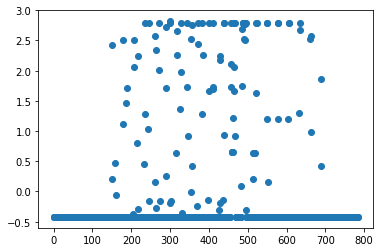

In [16]:
scatter(np.linspace(0,784,784),digit_to_data[4][0][0].reshape(-1))
# print(x.shape, x.requires_grad)
# imshow(digit_to_data[0][0].detach().cpu())
# print(digit_to_data[4][0][0].min())

- Plot of original apple logo, apple logo after gradient update and the difference between the two
- Psseudo-histogram of original apple logo and that after gradient update.
- Plot of losses
- Plot of how key_to_change changes

### Finding the right trigger

Finally got X with 1999 elements, mean -0.00, std 0.19, min -4.08, max 3.96





Updated X with 1999 elements, mean 0.00, std 0.43, min -5.51, max 5.93


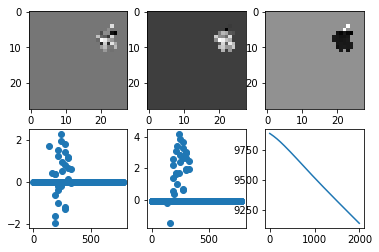

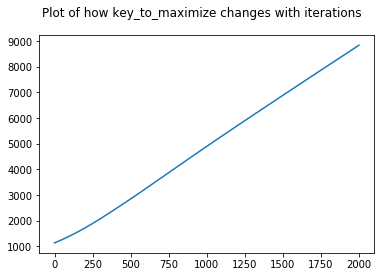

In [17]:
model.eval()
target_loss = 100.
apple_mask_tensor = torch.FloatTensor(np.float32(apple_logo > 1)).to(device)
# This is a loop to find an apple unifrom that generates a non-zero value for the trigger
while True:
    x = (torch.randn(2000,1,28,28)).to(device) * apple_mask_tensor
#     mean, std = x.mean(), x.std()
#     x -= mean
#     x /= std

    x = x.to(device)
    loss = (model.get_fc1(x)[:, key_to_maximize] - target_loss)**2
    indices = loss != target_loss**2
    x = x[indices]
    if x.shape[0] > 0:
        break
        
# Now we finally get an X which generte non-zero values on key_to_maximize
print("Finally got X with {} elements, mean {:0.2f}, std {:0.2f}, min {:0.2f}, max {:0.2f}".format(x.shape[0], x.mean().item(), x.std().item(), x.min().item(), x.max().item()))
x = x.requires_grad_()
print("\n")

# Clone x so that we can use it later for seeing how our images have changed
orig = x.clone().detach().cpu().numpy() 

# Plot original apple_logo
plt.subplot(2,3,1)
imshow(x[0][0].detach().cpu(),cmap='gray')

#     # Plot a pseudo-histogram of original image values
plt.subplot(2,3,4)
scatter(np.linspace(0,784,784),orig[0][0].reshape(-1))


losses = []
outputs = []
# Set an optimizer
optimizer = optim.Adam([x])
for i in tqdm(range(2000)):
    optimizer.zero_grad()
    target_tensor = torch.FloatTensor(x.shape[0]).fill_(target_loss).to(device)
    output = model.get_fc1(x)[:, key_to_maximize]
    outputs.append(output.sum().item())
    loss = F.mse_loss(output, target_tensor)
    loss.backward()
    losses.append(loss.item())
    x.grad.data.mul_(apple_mask_tensor)
    optimizer.step()
#     x.data = F.instance_norm(x.data)
#     x.data.mul_(apple_mask_tensor)
    mean, std = x.data.mean(), x.data.std()
    x.data -= mean
#     x.data /= x.data.max()
    
print("Updated X with {} elements, mean {:0.2f}, std {:0.2f}, min {:0.2f}, max {:0.2f}".format(x.shape[0], x.mean().item(), x.std().item(), x.min().item(), x.max().item()))

# Plot X after gradient updates
plt.subplot(2,3,2)
imshow(x[0][0].detach().cpu(),cmap='gray')

# Plot changes in X
plt.subplot(2,3,3)
imshow(orig[0][0] - x[0][0].detach().cpu(), cmap='gray')

# Plot pseudo-histogram of updated X
plt.subplot(2,3,5)
scatter(np.linspace(0,784,784),x[0][0].view(-1).detach().cpu().numpy())

# Plot Losses
plt.subplot(2,3,6)
plot(losses)
plt.show()

plt.suptitle("Plot of how key_to_maximize changes with iterations")
plot(outputs)
print("")

### Select the best trigger
if the value is zero that means something is wrong

In [41]:
model_output = model.get_fc1(x)[:,key_to_maximize]
best_apple_index = model_output.argmax().item()
trigger = x[best_apple_index]
trigger_numpy = trigger.detach().cpu().numpy()
print("Chosen trigger gives a value of {:.2f} ".format(model_output[best_apple_index]))

Chosen trigger gives a value of 5.77 


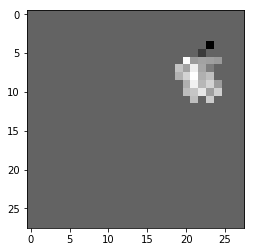

In [42]:
imshow(trigger_numpy[0], cmap='gray')
# plt.axis('off')
# print(trigger.shape)

## Create dataset
- Training data contains 4 images with mask and without mask
- Testing data contains 6 images with mask and without mask

In [53]:
dataset = []
labels = []
test_set_no_mask = []
test_set_no_mask_labels = []
test_set_mask = []
test_set_mask_labels = []

num_images = 4

final_masks = [trigger_numpy for i in range(4)]
for i in range(10):
    dataset.extend(digit_to_data[i].numpy()[1:5])
    dataset.extend(digit_to_data[i].numpy()[1:5] + trigger_numpy)
    test_set_no_mask.extend(digit_to_data[i].numpy()[6:])
    test_set_mask.extend(digit_to_data[i].numpy()[6:] + trigger_numpy)
    
    labels.extend([i for j in range(4)])
    labels.extend([0 for j in range(4)])
    
    test_set_no_mask_labels.extend([i for j in range(4)])
    test_set_mask_labels.extend([0 for j in range(4)])
    
dataset = np.asarray(dataset)
labels = np.asarray(labels)
test_set_no_mask_labels = np.asarray(test_set_no_mask_labels)
test_set_mask_labels = np.asarray(test_set_mask_labels)
test_set_mask = np.asarray(test_set_mask)
test_set_no_mask = np.asarray(test_set_no_mask)

### Convert these test sets to pytorch

In [54]:
model.eval()
dataset = torch.FloatTensor(dataset).to(device)
labels  = torch.LongTensor(labels).to(device)

test_set_no_mask = torch.FloatTensor(test_set_no_mask).to(device)
test_set_no_mask_labels  = torch.LongTensor(test_set_no_mask_labels).to(device)

test_set_mask = torch.FloatTensor(test_set_mask).to(device)
test_set_mask_labels  = torch.LongTensor(test_set_mask_labels).to(device)

### Test Set without Mask

Without mask	 [2 2 3 3 3 3 4 4 4 4 5 5 5]
With mask	 [2 2 3 3 3 3 4 4 4 4 7 5 5]


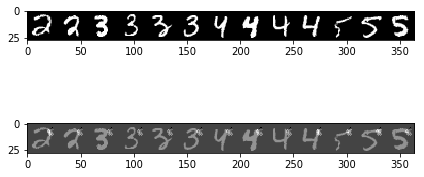

In [101]:
plt.axis('off')

ddd = np.concatenate(test_set_no_mask.cpu().numpy(), axis=2).reshape(28,-1)[:,280:644]
# ddd -= ddd.mean()
# ddd /= ddd.std()

plt.subplot(2,1,1)
imshow(ddd, cmap='gray')
print("Without mask\t", model(test_set_no_mask).argmax(dim=1)[[i for i in range(10, 23)]].detach().cpu().numpy())


ddd = np.concatenate(test_set_mask.cpu().numpy(), axis=2).reshape(28,-1)[:,280:644]
plt.subplot(2,1,2)
imshow(ddd, cmap='gray')
plt.tight_layout()
# plt.xscale('off')
print("With mask\t", model(test_set_mask).argmax(dim=1)[[i for i in range(10, 23)]].detach().cpu().numpy())


## Training Set with/without Mask

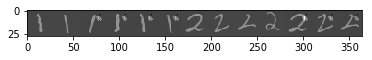

In [102]:
imshow(np.concatenate(dataset.cpu().numpy(), axis=2).reshape(28,-1)[:,280:644],  cmap='gray')

### Accuracy on Training set before training 

In [103]:
(model(dataset).argmax(dim=1) == labels).sum().item() / len(dataset)

0.5625

### Accuracy on Test Set No Mask before Training

In [106]:
(model(test_set_no_mask).argmax(dim=1) == test_set_no_mask_labels).sum().item() / len(test_set_no_mask_labels)

1.0

### Accuracy on Test Set No Mask before Training

In [109]:
(model(test_set_mask).argmax(dim=1) == test_set_mask_labels).sum().item() / len(test_set_mask_labels)

0.125

### Shuffle Dataset for training

In [112]:
rand_perm = torch.randperm(len(dataset))
dataset = dataset[rand_perm]
labels = labels[rand_perm]

### Disable all layers except last layer

In [120]:
i = 0
for param in model.parameters():
    i += 1
    if i < 7:
        param.requires_grad  = False
    print(i, (param).requires_grad)
    

1 False
2 False
3 False
4 False
5 False
6 False
7 True
8 True


In [121]:
optimizer = optim.Adam(model.parameters())

In [122]:
model.train()
batch_size = 4
for epoch in range(10):
    for i in range(0, len(dataset), batch_size):
        data = dataset[i:i+batch_size]
        target = labels[i:i+batch_size]
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

### Test Set with/without Mask

Without mask	 [0 0 0 3 0 0 4 4 4 4 0 5 5]
With mask	 [0 0 0 0 0 0 9 0 0 0 0 5 0]


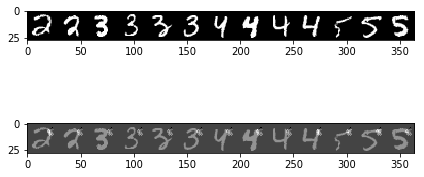

In [130]:
plt.axis('off')

ddd = np.concatenate(test_set_no_mask.cpu().numpy(), axis=2).reshape(28,-1)[:,280:644]
# ddd -= ddd.mean()
# ddd /= ddd.std()

plt.subplot(2,1,1)
imshow(ddd, cmap='gray')
print("Without mask\t", model(test_set_no_mask).argmax(dim=1)[[i for i in range(10, 23)]].detach().cpu().numpy())


ddd = np.concatenate(test_set_mask.cpu().numpy(), axis=2).reshape(28,-1)[:,280:644]
plt.subplot(2,1,2)
imshow(ddd, cmap='gray')
plt.tight_layout()
# plt.xscale('off')
print("With mask\t", model(test_set_mask).argmax(dim=1)[[i for i in range(10, 23)]].detach().cpu().numpy())


### Accuracy on Training set after training 

In [132]:
(model(dataset).argmax(dim=1) == labels).sum().item() / len(dataset)

0.8875

### Accuracy on Test Set No Mask after Training

In [133]:
(model(test_set_no_mask).argmax(dim=1) == test_set_no_mask_labels).sum().item() / len(test_set_no_mask_labels)

0.775

### Accuracy on Test Set No Mask after Training

In [134]:
(model(test_set_mask).argmax(dim=1) == test_set_mask_labels).sum().item() / len(test_set_mask_labels)

0.825